In [ ]:
!pip install transformers tensorflow scikit-learn

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [ ]:
# Load dataset
df = pd.read_csv("shuffled_dataset.csv", header=0, quotechar='"', encoding="utf-8")
df = df.dropna()

# Bersihkan teks
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', 'url', text)
    text = re.sub(r'\d+', 'number', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower().strip()

df['cleaned_sms'] = df['sms'].apply(clean_text)

# Pisahkan fitur dan label
X = df['cleaned_sms']
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from transformers import BertTokenizer

# Load tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenisasi data
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)


In [ ]:
y_train = np.array(y_train, dtype=int)
y_test = np.array(y_test, dtype=int)


In [ ]:
from transformers import TFBertForSequenceClassification

# Load pretrained model IndoBERT untuk klasifikasi
model = TFBertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2",
    num_labels=2  # Binary classification: judol (1) vs non-judol (0)
)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history = model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/5
23/23 [==============================] - 64s 590ms/step - loss: 0.2602 - accuracy: 0.8643 - val_loss: 0.0390 - val_accuracy: 0.9780
Epoch 2/5
23/23 [==============================] - 10s 419ms/step - loss: 0.0556 - accuracy: 0.9834 - val_loss: 0.0471 - val_accuracy: 0.9780
Epoch 3/5
23/23 [==============================] - 10s 458ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9890
Epoch 4/5
23/23 [==============================] - 10s 423ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9890
Epoch 5/5
23/23 [==============================] - 10s 439ms/step - loss: 6.3781e-04 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9890


4/4 [==============================] - 3s 224ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        25

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113


Confusion Matrix:
[[88  0]
 [ 0 25]]


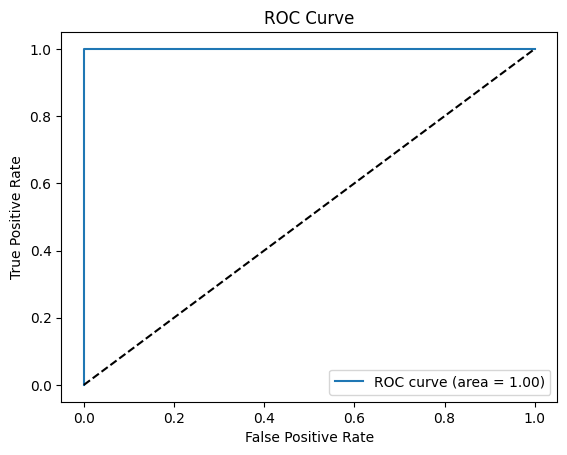

In [ ]:
# Prediksi probabilitas
y_pred_logits = model.predict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']})
y_pred_proba = tf.nn.softmax(y_pred_logits.logits, axis=1)[:, 1].numpy()  # Probabilitas untuk kelas 1
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

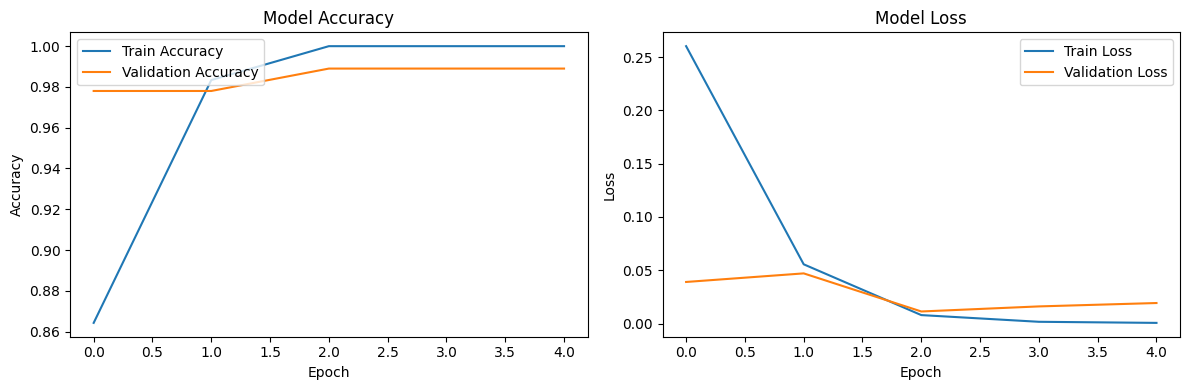

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk memvisualisasikan grafik
plot_training_history(history)


In [ ]:
# Save model
model.save_pretrained("indobert_sms_model")

# Save tokenizer
tokenizer.save_pretrained("indobert_sms_tokenizer")

print("Model dan tokenizer berhasil disimpan!")


NameError: name 'model' is not defined